In [2]:
from datetime import date
today = str(date.today())
from btgenerate.database.database import Database
from btgenerate.database.dataloader import LiquidMasterTableDataSet
from pprint import PrettyPrinter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(f"./weekly_updates/weekly_updates_{today}.pdf")

pp = PrettyPrinter(width=80, compact=True)
# %reload_ext autoreload
# %autoreload 1
# %aimport btgenerate.chemicals.chemical
# %aimport btgenerate.database.database


In [3]:
ds_lm = LiquidMasterTableDataSet()
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass(g)", inplace=True)

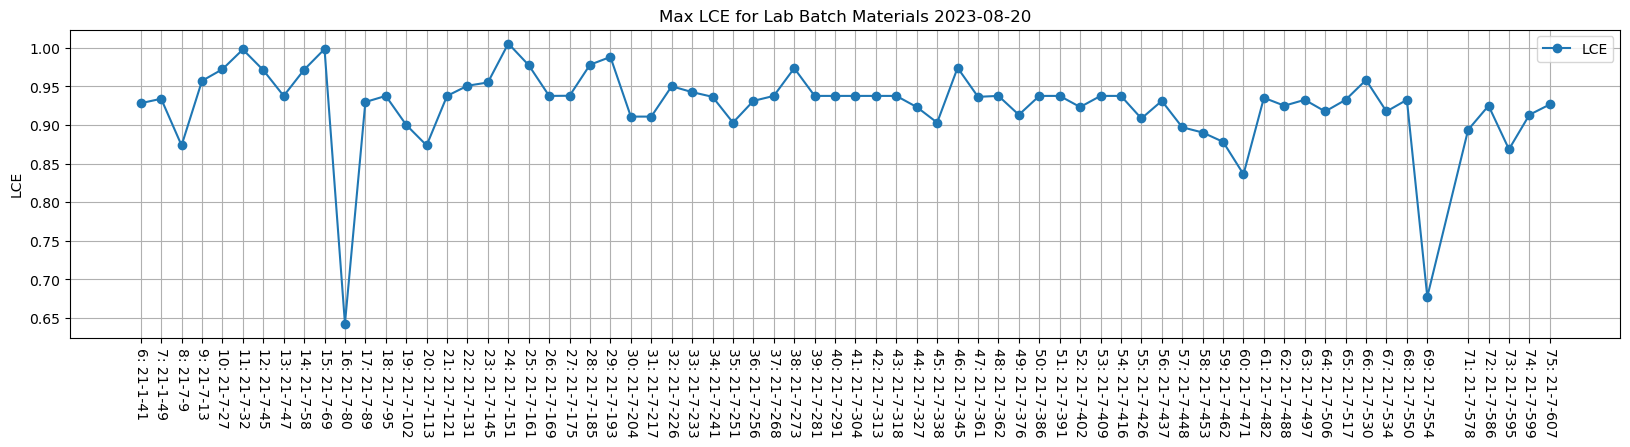

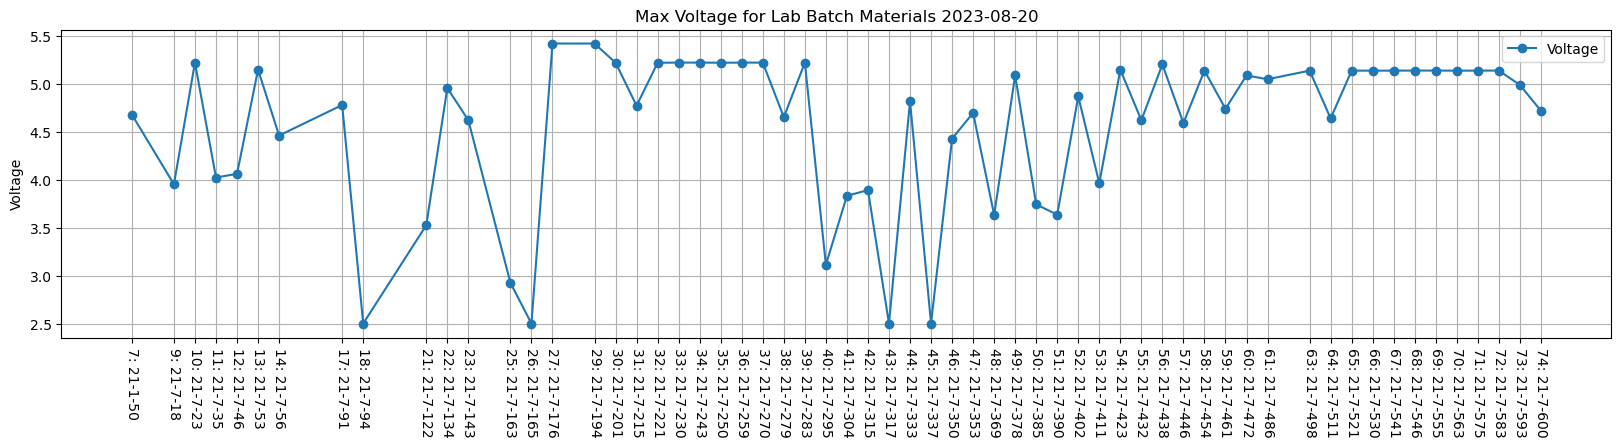

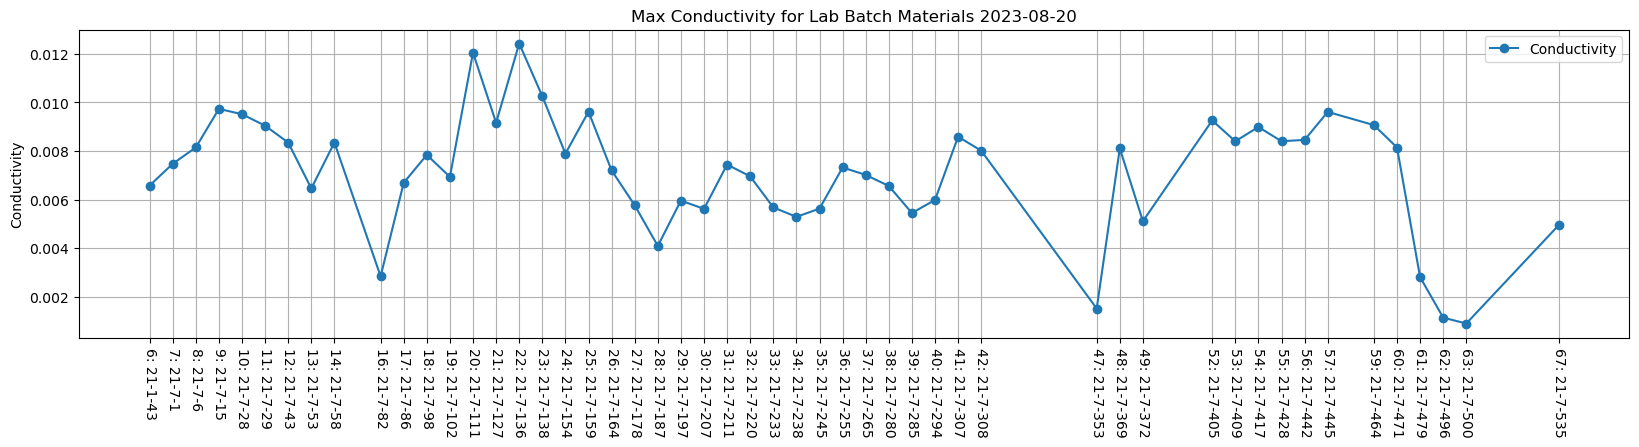

In [4]:
df = ds_lm.dataframe
for target in ["LCE", "Voltage", "Conductivity"]:

    indices_batch_max = []
    problematic_batches = []
    for batch, indices in df.groupby("lab_batch").groups.items():
        index_batch_max = df.loc[indices, target].idxmax()
        if not np.isnan(index_batch_max):
            indices_batch_max.append(index_batch_max)
        else:
            problematic_batches.append(batch)
    df_ = df.loc[indices_batch_max, ["lab_batch", "Electrolyte ID", target]]

    fig, ax = plt.subplots(figsize=(20,4))
    df_.plot(x="lab_batch", y=target, marker="o", ax=ax)
    ax.set_xticks(df_["lab_batch"])
    ticks = list(map(lambda x: str(int(x[0])) + ": " + x[1], df_.loc[:, ["lab_batch","Electrolyte ID"]].to_numpy()))
    ax.set_xticklabels(ticks, rotation=-90, ha="center", va="top")
    # if target == "LCE":
    #     ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel("")
    ax.set_title(f"Max {target} for Lab Batch Materials {today}")
    ax.set_ylabel(target)
    ax.legend()
    ax.grid(1)
    pdf.savefig(fig, bbox_inches="tight")
    plt.show()

In [5]:
df_ = ds_lm.dataframe.dropna(subset=["LCE", "Predicted LCE"])
df_["id"] = df["Electrolyte ID"].str.replace("-", "").astype(int)
df_ = df_.sort_values(axis="index", by="id")
df_ = df_.loc[:, ["Electrolyte ID", "LCE", "Predicted LCE"]].reset_index(drop=True)

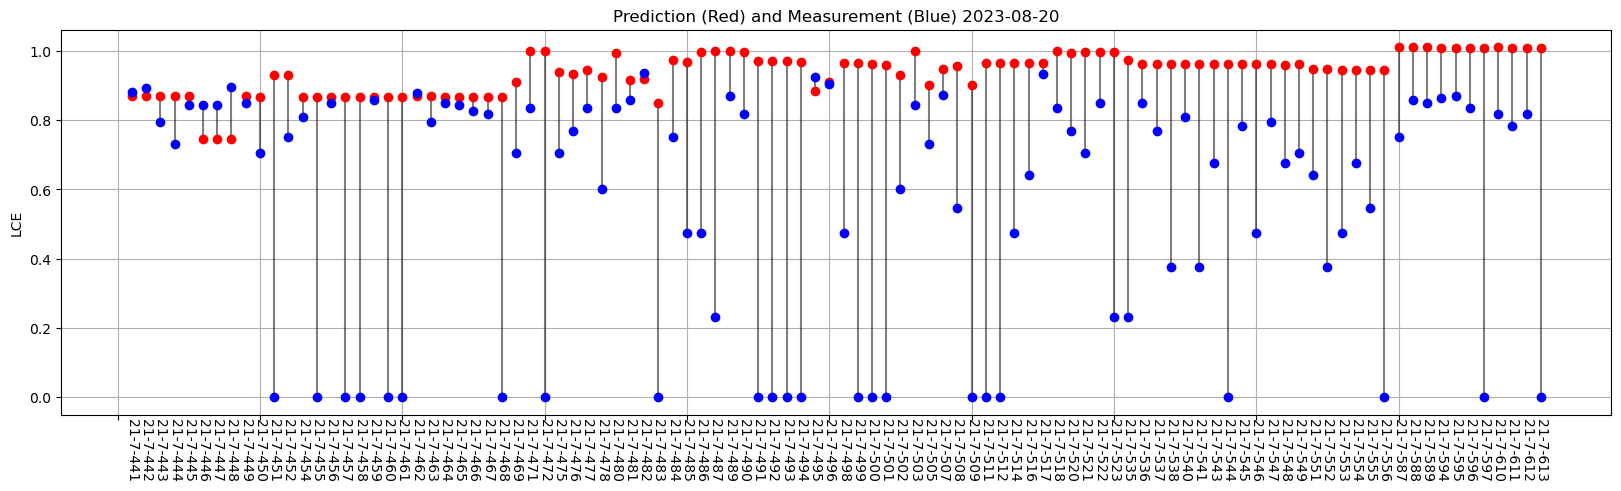

In [6]:
num_from_last = 100
fig, ax = plt.subplots(figsize=(20,5))
for row in df_.tail(num_from_last).iterrows():
    ax.plot([row[0]]*2, [row[1]["LCE"], row[1]["Predicted LCE"]], color="k", alpha=0.5)
    ax.plot(row[0], row[1]["Predicted LCE"], color="r", marker="o")
    ax.plot(row[0], row[1]["LCE"], color="b", marker="o")
    ax.text(row[0], -0.06, row[1]["Electrolyte ID"], rotation=-90, ha="center", va="top")
ax.set_xticks(np.arange(row[0]-num_from_last, row[0], 10))
ax.set_xticklabels([])
ax.set_title(f"Prediction (Red) and Measurement (Blue) {today}")
ax.set_ylabel("LCE")
ax.grid(1, which="both", )
pdf.savefig(fig, bbox_inches="tight")
plt.show()


In [7]:
db = Database(db="bo_experiments")
df = db.pull(table="validated_lce_v1")
ds_lm = LiquidMasterTableDataSet(df)
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass", inplace=True)
df_sort = ds_lm.dataframe.sort_values(axis="index", by="Electrolyte ID")

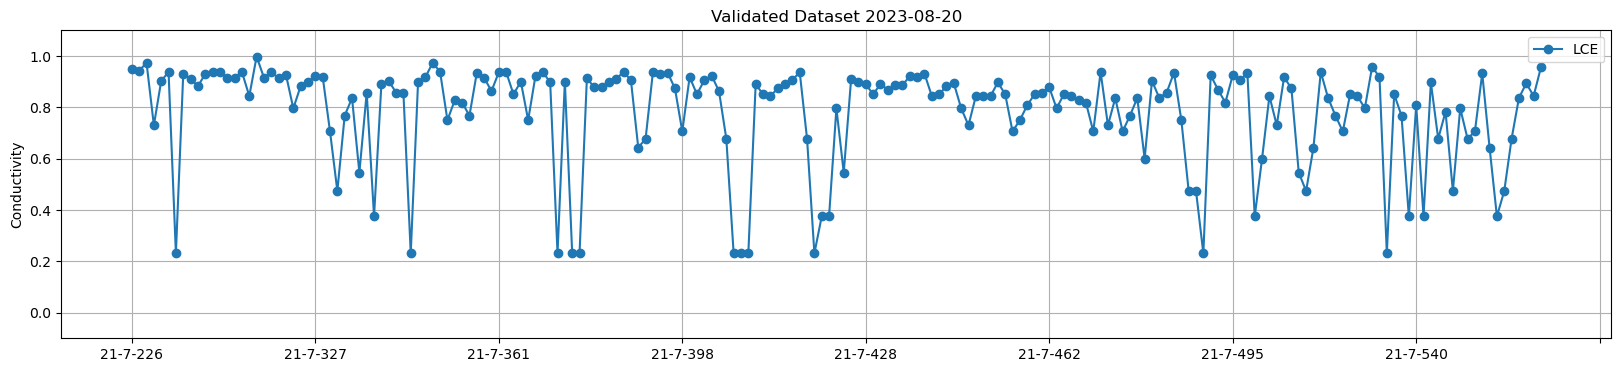

In [8]:
fig, ax = plt.subplots(figsize=(20,4))
df_sort.plot(x="Electrolyte ID", y="LCE", marker="o", ax=ax)
# ax.set_xticks(df_sort["lab_batch"])
# ticks = list(map(lambda x: str(int(x[0])) + ": " + x[1], df_.loc[:, ["lab_batch","Electrolyte ID"]].to_numpy()))
# ax.set_xticklabels(ticks, rotation=-90, ha="center", va="top")
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel("")
ax.set_ylabel(target)
ax.set_title(f"Validated Dataset {today}")
ax.legend()
ax.grid(1)
pdf.savefig(fig, bbox_inches="tight")
plt.show()

In [9]:
pdf.close()